# Restricted Boltzmann Machines

In this exercise, we will train a restricted Boltzmann machine (RBM) on a subset of the MNIST data consisting of all handwritten digits of class 0. There are approximately 6900 of them. The code below loads usual libraries, extracts the desired subset of the MNIST data, and converts it into binary format using the pixel intensity 127.5 as a quantization threshold.

In [1]:
import numpy
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_mldata

MNIST = fetch_mldata('MNIST original')
X = MNIST['data']
T = MNIST['target']
X = (X[T==0] > 127.5)*1.0

The data can be visualized as a mosaic where each tile corresponds to one handwritten digit. Here, the first 50 digits of the dataset are shown.

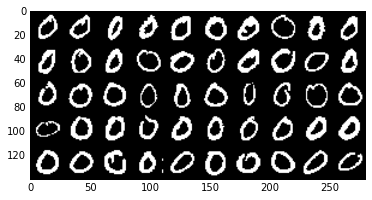

In [2]:
plt.figure(figsize=(6,3))
plt.imshow(X[:50].reshape(5,10,28,28).transpose(0,2,1,3).reshape(5*28,10*28),cmap='gray')
plt.show()

## The RBM class

The restricted Boltzmann machine can be defined a class, with various method implementing the basic operations necessary for training, in particular, sampling, inference, gradient computation, and parameter update. The method **`__init__`**`(self,m,n)` initializes the parameters of the Boltzmann machine to small random values, where `d` and `N` denote the number of visible and hidden units respectively. The function **`infer`**`(self,x)` computes the vector of probabilities of hidden units activations given a certain input vector `x`. The method **`gibbs`**`(self,x,k)` performs `k` step of Gibbs sampling where one step is understood as successively sampling hidden variables given input `x`, and sampling visible variables given the just sampled hidden variables. The method **`gradient`**`(self,xd,xm)` computes the gradient in the parameter space based on the data sample `xd` and the sample `xm` generated by the model, either a true sample, or an approximation. Finally, the method **`update`**`(self,lr)` performs a gradient step based on the gradient computed just before with a certain learning rate `lr` received as parameter.

In addition, a function **`sigm`**`(z)` computes the logistic sigmoid function $\sigma(z) = e^z / (1+e^z)$ in a numerically stable manner using the hyperbolic tangent, and the function **`bernoulli`**`(p)` samples from a Bernoulli distribution with parameter `p` given as input. Note that both functions apply element-wise.

In [3]:
def sigm(z): return numpy.tanh(0.5*z)*0.5+0.5


def bernoulli(p): return (p>numpy.random.uniform(0,1,p.shape))*1.0


class RBM:
    
    def __init__(self,d,N):
        self.A = numpy.zeros([d])
        self.W = numpy.random.normal(0,0.04,[d,N])
        self.B = numpy.zeros([N])

    def infer(self,x):
        h = sigm(numpy.dot(x,self.W)+self.B)
        return h
    
    def gibbs(self,x,k):
        for i in range(k):
            h = bernoulli(sigm(numpy.dot(x,self.W)+self.B))
            x = bernoulli(sigm(numpy.dot(h,self.W.T)+self.A))
        return x

    def gradient(self,xd,xm):
        hd = self.infer(xd)
        hm = self.infer(xm)
        self.DW = numpy.outer(xm,hm) - numpy.outer(xd,hd)
        self.DB = (hm - hd)
        self.DA = (xm - xd)
        
    def update(self,lr):
        self.W -= lr*self.DW
        self.B -= lr*self.DB
        self.A -= lr*self.DA

## Training an RBM (20 P)

We first create an RBM instance with 784 visible units and 50 hidden units. The number of visible units corresponds to the dimensions of the data, and the number of hidden units controls the complexity of the model.

In [4]:
rbm = RBM(784,50)

The goal of this exercise is to write a training procedure for the RBM based on the methods of the `RBM` class above. The training procedure is based on stochastic gradient descent (i.e. approximating the gradient from a single example in the data and in the model), and perform gradient descent using this approximate gradient. The training procedure consists of repeatedly

* drawing a random example from the dataset and generating a sample from the model, and
* computing the gradient and updating the model parameters accordingly.

To generate a sample from the model, we will use a procedure called CD-k (contrastive divergence with `k` Gibbs sampling steps). The CD-`k` method for sampling consists of starting from the current data point, and performing `k` steps of Gibbs sampling. Here, we use `k=5`.

Once the training procedure is implemented, the Boltzmann machine should be trained for 20000 iterations (the training procedure should take approximately one minute). For the first 10000 iterations use a learning rate `lr=0.004`, and for the remaining 10000 iterations, use a learning rate `lr=0.0004`.

In [5]:
def train(rbm, X, steps=20000, learning_rates=((10000, 0.004), (20000, 0.0004)), k=5):
    data_len = len(X)
    learning_rates = numpy.array(learning_rates)
    example_ids = numpy.arange(data_len)
    example_ids = numpy.random.choice(example_ids, size=steps, replace=True)
    for i, example_id in enumerate(example_ids):
        example = X[example_id]
        sampled = rbm.gibbs(example, k)
        rbm.gradient(example, sampled)
        valid_lrs = learning_rates[learning_rates[:, 0] > i]
        lr = valid_lrs[numpy.argmin(valid_lrs[:, 0]), 1]
        rbm.update(lr)

train(rbm, X)

Once the RBM has been trained, run the following code to verify visually that it has learned meaningful features of the data. The code below produces a mosaic, where each tile of the mosaic corresponds to the weights associated to a given hidden unit of the model. A successful training procedure will lead to a set of weights that are sufficiently rich to model the variety of zeros present in the dataset.

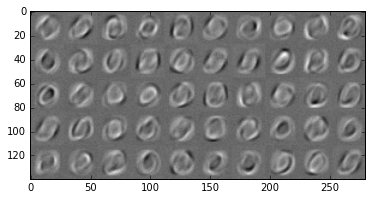

In [6]:
plt.figure(figsize=(6,3))
plt.imshow(rbm.W.reshape(28,28,5,10).transpose(2,0,3,1).reshape(5*28,10*28),cmap='gray')
plt.show()

## Likely and unlikely digits (20 P)

Evaluating an RBM in a quantitative manner is difficult. In particular, it is not possible to evaluate directly the log-probability function $\log p_\theta(\boldsymbol{x}) = -F_\theta(\boldsymbol{x}) - \log(Z_\theta)$ due to the partition function $Z_\theta$ whose computation involves an exponential number of terms. However, because $Z_\theta$ is constant for the model, we can still measure *differences* of probabilities between examples. This allows us to rank MNIST digits from the most to the least likely according to the RBM model. As a reminder, for the RBM considered here, the free energy function is given by the formula:
$$
F_\theta(\boldsymbol{x}) =
-\boldsymbol{a}^\top \boldsymbol{x}
- \sum_{j=1}^{N} \log(1+\exp(\boldsymbol{w}_j^\top \boldsymbol{x} + b_j))
$$
where $N$ is the number of hidden units and $\boldsymbol{w}_j$ is the vector of weights associated to the hidden unit $h_j$ of the RBM. One such vector corresponds to a particular tile of the mosaic of weights plotted above.

Retrieve the 50 most likely and least likely handwritten digits according to the trained RBM model.

In [7]:
def F(rmb, X):
    return -numpy.dot(X, rbm.A) - numpy.log1p(numpy.exp(numpy.dot(X, rbm.W) + rbm.B)).sum(axis=1)

energies = F(rbm, X)
indexes = numpy.argsort(energies)

Xlikely, Xunlikely = X[indexes[:50]], X[indexes[-50:]]

The code below plots the most likely and least likely handwritten digits that have been found. Results should verify the intuition that the most regular digits are perceived as likely by the RBM, whereas the irregular ones (e.g. composed of a middle bar, cropped, or very thick) are perceived as unlikely.

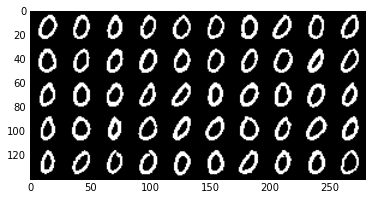

In [8]:
plt.figure(figsize=(6,3))
plt.imshow(Xlikely.reshape(5,10,28,28).transpose(0,2,1,3).reshape(5*28,10*28),cmap='gray')
plt.show()

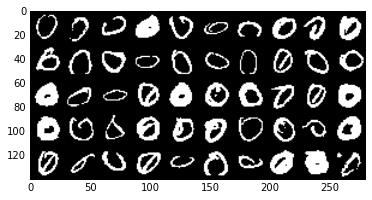

In [9]:
plt.figure(figsize=(6,3))
plt.imshow(Xunlikely.reshape(5,10,28,28).transpose(0,2,1,3).reshape(5*28,10*28),cmap='gray')
plt.show()

## Sampling from the model (20 P)

As a result of training, the RBM has learned a distribution $p_\theta$ over binary images. Furthermore, we can sample from this distribution using the Gibbs sampler readily implemented in the `RBM` class. Write code for repeatedly sampling from the model, and visualizing the obtained samples. Starting from the first example `X[0]` in the dataset, perform `1250` steps of Gibbs sampling, and show the current sample every `25` iterations. This procedure should result in a sequence of `50` handwritten digits to visualize, and that can be shown as a mosaic.

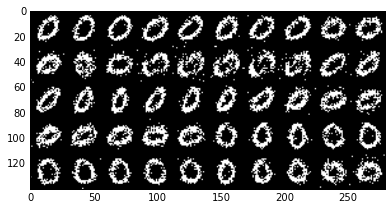

In [10]:
sample = X[0]
samples = numpy.zeros((50, len(sample)))
for i in range(50):
    sample = rbm.gibbs(sample, k=25)
    samples[i] = sample

f = plt.figure(figsize=(6, 3))
ax = f.gca()
ax.imshow(samples.reshape(5, 10, 28, 28).transpose(0, 2, 1, 3).reshape(5*28, 10*28),cmap='gray')
f.tight_layout()